In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load saved data
from google.colab import drive
drive.mount('/content/drive')
data = np.load('/content/drive/My Drive/Github/mtc-device-activation/data/activity-models/e2-general-model.npz', allow_pickle=True)
all_DeviceLocations = data['all_DeviceLocations']
num_samples = data['num_samples']
device_count = data['device_count']
sparsity = data['sparsity']

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-theta.npz", allow_pickle=True)
all_theta = data["all_theta"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-gamma.npz", allow_pickle=True)
all_gamma = data["all_gamma"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-z.npz", allow_pickle=True)
all_z = data["all_z"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-noise.npz", allow_pickle=True)
all_noise = data["all_noise"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-received-signal.npz", allow_pickle=True)
all_received_signal = data["all_received_signal"]

data = np.load("/content/drive/My Drive/Github/mtc-device-activation/data/communication-models/e2-communication-simulation-general.npz", allow_pickle=True)
snr_db_array = data["snr_db_array"]
pilot_length_array = data["pilot_length_array"]
M = data["M"]

pilot_length_index = 2
pilot_length=pilot_length_array[pilot_length_index]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
num_samples = 1000
sample_range = range(200, 400)

Sparse Bayesian Learning (SBL)

In [4]:
def sbl_algorithm(theta, y, noise_var, max_iter=500, stopping_criterion=1e-4):
    # Sparse Bayesian Learning (SBL) for Multiple Measurement Vectors (MMV).

    M = y.shape[1]  # Number of antennas (columns of y)

    L = theta.shape[0]  # Pilot Length (rows of theta)
    N = theta.shape[1] # Number of MTDs (columns of theta)

    # Initialize Gamma (covariance matrix of the signal)
    Gamma = np.eye(N) * 0.1  # Initial guess: identity matrix

    # Iterative update process
    for t in range(max_iter):
       # E-Step: Compute the mean (mu_x) and covariance (Sigma_x) of x
        Sigma_y = theta @ Gamma @ theta.conj().T + noise_var * np.eye(L)
        Sigma_y_inv = np.linalg.inv(Sigma_y)
        Sigma_x = Gamma - Gamma @ theta.conj().T @ Sigma_y_inv @ theta @ Gamma
        mu_x = Gamma @ theta.conj().T @ Sigma_y_inv @ y

        # Compute gamma update using the derived formula
        gamma_new = (np.linalg.norm(mu_x, axis=1) ** 2) / M + np.real(np.diag(Sigma_x))

        # Ensure non-negativity for numerical stability
        gamma_new = np.maximum(gamma_new, 1e-8)

        # Check for convergence: if change is below threshold, stop iterations
        if np.linalg.norm(gamma_new - np.diag(Gamma)) < stopping_criterion:
            print(f"Converged after {t+1} iterations")
            break

        # Update Gamma with new values
        Gamma = np.diagflat(gamma_new)

    # Return final estimates
    return mu_x, np.diag(Gamma)


In [5]:
# Placeholder arrays for results
z_res = np.zeros((num_samples, len(snr_db_array), device_count, M), dtype=np.complex128)  # Z estimates
gamma_res = np.zeros((num_samples, len(snr_db_array), device_count), dtype=bool)  # Gamma support

hr_res = np.zeros((num_samples, len(snr_db_array)))         # HR
fr_res = np.zeros((num_samples, len(snr_db_array)))         # FR
srr_res = np.zeros((num_samples, len(snr_db_array)))        # SRR
precision_res = np.zeros((num_samples, len(snr_db_array)))  # Precision
recall_res = np.zeros((num_samples, len(snr_db_array)))     # Recall
f1_res = np.zeros((num_samples, len(snr_db_array)))         # F1
nmse_res = np.zeros((num_samples, len(snr_db_array)))       # NMSE

In [6]:
# Loop through each sample with an outer progress bar
for sample_index in tqdm(sample_range, desc="Processing Samples", position=0):
    theta = all_theta[sample_index, pilot_length_index, :pilot_length]
    gamma = all_gamma[sample_index]  # Ground truth gamma values (true support)
    loc = all_DeviceLocations[sample_index]

    # Loop over each SNR level with an inner progress bar
    for snr_db_index in tqdm(range(len(snr_db_array)), desc="Processing SNR Levels", leave=False, position=1):
        received_signal = all_received_signal[sample_index, pilot_length_index, snr_db_index, :pilot_length]
        z = all_z[sample_index]
        snr_db = snr_db_array[snr_db_index]
        snr = 10 ** (snr_db / 10)
        signal_power = np.mean(np.abs(np.matmul(theta, z))**2)
        noise_power = signal_power / snr

        # Apply SBL algorithm for the current sample and SNR level
        z_result, gamma_result = sbl_algorithm(theta, received_signal, noise_power)

        # Zero-out results with low gamma values
        z_result[gamma_result <= 0.05] = 0
        z_res[sample_index, snr_db_index, :, :] = z_result
        gamma_result_bool = gamma_result > 0.05
        gamma_res[sample_index, snr_db_index, :] = gamma_result_bool

        # Compute number of active/inactive devices from ground truth
        active_devices = np.sum(gamma == 1)
        inactive_devices = np.sum(gamma == 0)

        # Hit rate: percentage of correctly identified active devices
        hr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 1)) / active_devices if active_devices > 0 else 0
        )

        # False alarm rate: percentage of inactive devices wrongly detected as active
        fr_res[sample_index, snr_db_index] = (
            100 * np.sum((gamma_result_bool == 1) & (gamma == 0)) / inactive_devices if inactive_devices > 0 else 0
        )

        # Support recovery rate: proportion of correctly identified active devices
        srr_res[sample_index, snr_db_index] = (
            np.sum((gamma_result_bool == 1) & (gamma == 1)) /
            (np.sum((gamma_result_bool == 1) & (gamma == 0)) + np.sum((gamma_result_bool == 0) & (gamma == 1)) + sparsity)
        )

        # Classification metrics: TP, FP, FN
        TP = np.sum((gamma_result_bool == 1) & (gamma == 1))
        FP = np.sum((gamma_result_bool == 1) & (gamma == 0))
        FN = np.sum((gamma_result_bool == 0) & (gamma == 1))

        # Precision: proportion of predicted active devices that are actually active
        precision_res[sample_index, snr_db_index] = TP / (TP + FP) if (TP + FP) > 0 else 0

        # Recall: proportion of actual active devices that are correctly identified
        recall_res[sample_index, snr_db_index] = TP / (TP + FN) if (TP + FN) > 0 else 0

        # F1 Score: harmonic mean of precision and recall
        if (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index]) > 0:
            f1_res[sample_index, snr_db_index] = (
                2 * precision_res[sample_index, snr_db_index] * recall_res[sample_index, snr_db_index]
                /
                (precision_res[sample_index, snr_db_index] + recall_res[sample_index, snr_db_index])
            )
        else:
            f1_res[sample_index, snr_db_index] = 0

        # Normalized Mean Squared Error: compares estimated and true z vectors for active devices
        nmse_res[sample_index, snr_db_index] = (
            np.linalg.norm(z[gamma == 1] - z_result[gamma == 1])**2 / np.linalg.norm(z[gamma == 1])**2
        )


Processing Samples:   2%|▏         | 3/200 [05:00<5:26:39, 99.49s/it] 

Converged after 399 iterations



Processing Samples:   6%|▌         | 11/200 [18:14<5:12:33, 99.22s/it]

Converged after 490 iterations



Processing Samples:   7%|▋         | 14/200 [23:02<5:00:25, 96.91s/it]

Converged after 443 iterations



Processing Samples:   8%|▊         | 15/200 [24:36<4:55:40, 95.90s/it]

Converged after 386 iterations



Processing Samples:   8%|▊         | 16/200 [26:12<4:54:43, 96.11s/it]

Converged after 470 iterations



Processing Samples:  12%|█▏        | 23/200 [37:31<4:43:47, 96.20s/it]

Converged after 383 iterations



Processing Samples:  12%|█▏        | 24/200 [39:10<4:44:17, 96.92s/it]

Converged after 477 iterations



Processing Samples:  12%|█▎        | 25/200 [40:45<4:40:46, 96.26s/it]

Converged after 465 iterations



Processing Samples:  13%|█▎        | 26/200 [42:23<4:40:41, 96.79s/it]

Converged after 470 iterations



Processing Samples:  14%|█▎        | 27/200 [43:56<4:36:04, 95.75s/it]

Converged after 422 iterations



Processing Samples:  15%|█▌        | 30/200 [48:45<4:31:50, 95.94s/it]

Converged after 424 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.55s/it]

Converged after 484 iterations



Processing Samples:  23%|██▎       | 46/200 [1:14:34<4:07:10, 96.31s/it]

Converged after 392 iterations



Processing Samples:  29%|██▉       | 58/200 [1:33:58<3:49:50, 97.11s/it]

Converged after 494 iterations



Processing Samples:  36%|███▌      | 72/200 [1:56:34<3:25:52, 96.50s/it]

Converged after 429 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.41s/it]

Converged after 444 iterations



Processing Samples:  36%|███▋      | 73/200 [1:58:06<3:21:43, 95.30s/it]

Converged after 437 iterations



Processing Samples:  40%|████      | 81/200 [2:11:02<3:12:03, 96.83s/it]

Converged after 476 iterations



Processing Samples:  42%|████▎     | 85/200 [2:17:25<3:03:55, 95.96s/it]

Converged after 424 iterations



Processing Samples:  43%|████▎     | 86/200 [2:19:02<3:02:47, 96.20s/it]

Converged after 465 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:18<00:15, 15.51s/it]

Converged after 460 iterations



Processing Samples:  44%|████▎     | 87/200 [2:20:34<2:58:39, 94.86s/it]

Converged after 406 iterations



Processing Samples:  44%|████▍     | 89/200 [2:23:47<2:57:17, 95.83s/it]

Converged after 482 iterations



Processing Samples:  46%|████▌     | 91/200 [2:26:58<2:53:20, 95.41s/it]

Converged after 401 iterations



Processing Samples:  48%|████▊     | 95/200 [2:33:22<2:46:53, 95.37s/it]

Converged after 415 iterations



Processing Samples:  49%|████▉     | 98/200 [2:38:11<2:43:17, 96.06s/it]

Converged after 417 iterations



Processing Samples:  51%|█████     | 102/200 [2:44:39<2:37:37, 96.51s/it]

Converged after 499 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:20<00:15, 15.59s/it]

Converged after 445 iterations



Processing Samples:  52%|█████▎    | 105/200 [2:49:25<2:30:59, 95.36s/it]

Converged after 366 iterations



Processing Samples:  54%|█████▍    | 108/200 [2:54:16<2:28:06, 96.60s/it]

Converged after 485 iterations



Processing Samples:  55%|█████▌    | 110/200 [2:57:25<2:23:18, 95.54s/it]

Converged after 404 iterations



Processing Samples:  56%|█████▌    | 111/200 [2:59:00<2:21:24, 95.33s/it]

Converged after 433 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:17<00:15, 15.18s/it]

Converged after 427 iterations



Processing Samples:  56%|█████▌    | 112/200 [3:00:31<2:18:01, 94.11s/it]

Converged after 423 iterations



Processing Samples:  58%|█████▊    | 116/200 [3:07:00<2:15:12, 96.58s/it]

Converged after 451 iterations



Processing Samples:  60%|██████    | 121/200 [3:15:05<2:07:44, 97.02s/it]

Converged after 471 iterations



Processing Samples:  66%|██████▌   | 131/200 [3:31:13<1:51:37, 97.07s/it]

Converged after 488 iterations



Processing Samples:  68%|██████▊   | 136/200 [3:39:17<1:43:12, 96.75s/it]

Converged after 452 iterations



Processing Samples:  70%|███████   | 140/200 [3:45:41<1:35:55, 95.93s/it]

Converged after 447 iterations



Processing Samples:  70%|███████   | 141/200 [3:47:18<1:34:41, 96.30s/it]

Converged after 467 iterations



Processing Samples:  71%|███████   | 142/200 [3:48:52<1:32:20, 95.53s/it]

Converged after 468 iterations



Processing Samples:  72%|███████▏  | 143/200 [3:50:29<1:31:05, 95.88s/it]

Converged after 433 iterations



Processing Samples:  73%|███████▎  | 146/200 [3:55:16<1:26:09, 95.73s/it]

Converged after 450 iterations



Processing Samples:  74%|███████▍  | 148/200 [3:58:27<1:22:35, 95.29s/it]

Converged after 406 iterations



Processing Samples:  74%|███████▍  | 149/200 [4:00:04<1:21:25, 95.79s/it]

Converged after 469 iterations



Processing Samples:  81%|████████  | 162/200 [4:21:05<1:01:19, 96.83s/it]

Converged after 410 iterations



Processing SNR Levels:  83%|████████▎ | 5/6 [01:22<00:16, 16.30s/it]

Converged after 499 iterations



Processing Samples:  88%|████████▊ | 176/200 [4:43:46<38:43, 96.83s/it]

Converged after 455 iterations



Processing Samples:  89%|████████▉ | 178/200 [4:46:59<35:16, 96.21s/it]

Converged after 446 iterations



Processing Samples:  90%|█████████ | 181/200 [4:51:46<30:19, 95.76s/it]

Converged after 367 iterations



Processing Samples:  95%|█████████▌| 190/200 [5:06:15<15:57, 95.72s/it]

Converged after 380 iterations



Processing Samples: 100%|█████████▉| 199/200 [5:20:50<01:37, 97.56s/it]

Converged after 490 iterations



Processing Samples: 100%|██████████| 200/200 [5:22:24<00:00, 96.72s/it]

Converged after 456 iterations


In [7]:
# Compute the average across all samples for each SNR level
avg_hr = np.mean(hr_res, axis=0)         # HR
avg_srr = np.mean(srr_res, axis=0)       # SRR
avg_fr = np.mean(fr_res, axis=0)         # FR
avg_pr = np.mean(precision_res, axis=0)  # Precision
avg_re = np.mean(recall_res, axis=0)     # Recall
avg_f1 = np.mean(f1_res, axis=0)         # F1
avg_nmse = np.mean(nmse_res, axis=0)     # NMSE

# Print average results
print("Avg HR  :", avg_hr)
print("Avg SRR :", avg_srr)
print("Avg FR  :", avg_fr)
print("Avg PR  :", avg_pr)
print("Avg RE  :", avg_re)
print("Avg F1  :", avg_f1)
print("Avg NMSE:", avg_nmse)

Avg HR  : [11.06  15.19  18.28  19.735 19.975 19.995]
Avg SRR : [0.04557305 0.07853846 0.12534366 0.18096491 0.199      0.19990476]
Avg FR  : [1.09973684 0.79605263 0.44052632 0.09210526 0.00289474 0.        ]
Avg PR  : [0.06986074 0.10124019 0.13873574 0.18461663 0.19947619 0.2       ]
Avg RE  : [0.1106  0.1519  0.1828  0.19735 0.19975 0.19995]
Avg F1  : [0.08539672 0.12126808 0.15741385 0.19057258 0.1996035  0.19997436]
Avg NMSE: [0.12885575 0.08674138 0.04444937 0.01469294 0.00465818 0.00176989]


In [8]:
np.savez_compressed(
    '/content/drive/My Drive/Github/mtc-device-activation/data/results/e2-results-1000-sbl-snr-db-all-pilot-length-30-set-2.npz',
    z_res=z_res,
    gamma_res=gamma_res,
    hr_res=hr_res,
    fr_res=fr_res,
    srr_res=srr_res,
    precision_res=precision_res,
    recall_res=recall_res,
    f1_res=f1_res,
    nmse_res=nmse_res,
    avg_hr=avg_hr,
    avg_fr=avg_fr,
    avg_srr=avg_srr,
    avg_pr=avg_pr,
    avg_re=avg_re,
    avg_f1=avg_f1,
    avg_nmse=avg_nmse,
    pilot_length=pilot_length,
    snr_db_array=snr_db_array
)

print("All results have been saved")

All results have been saved


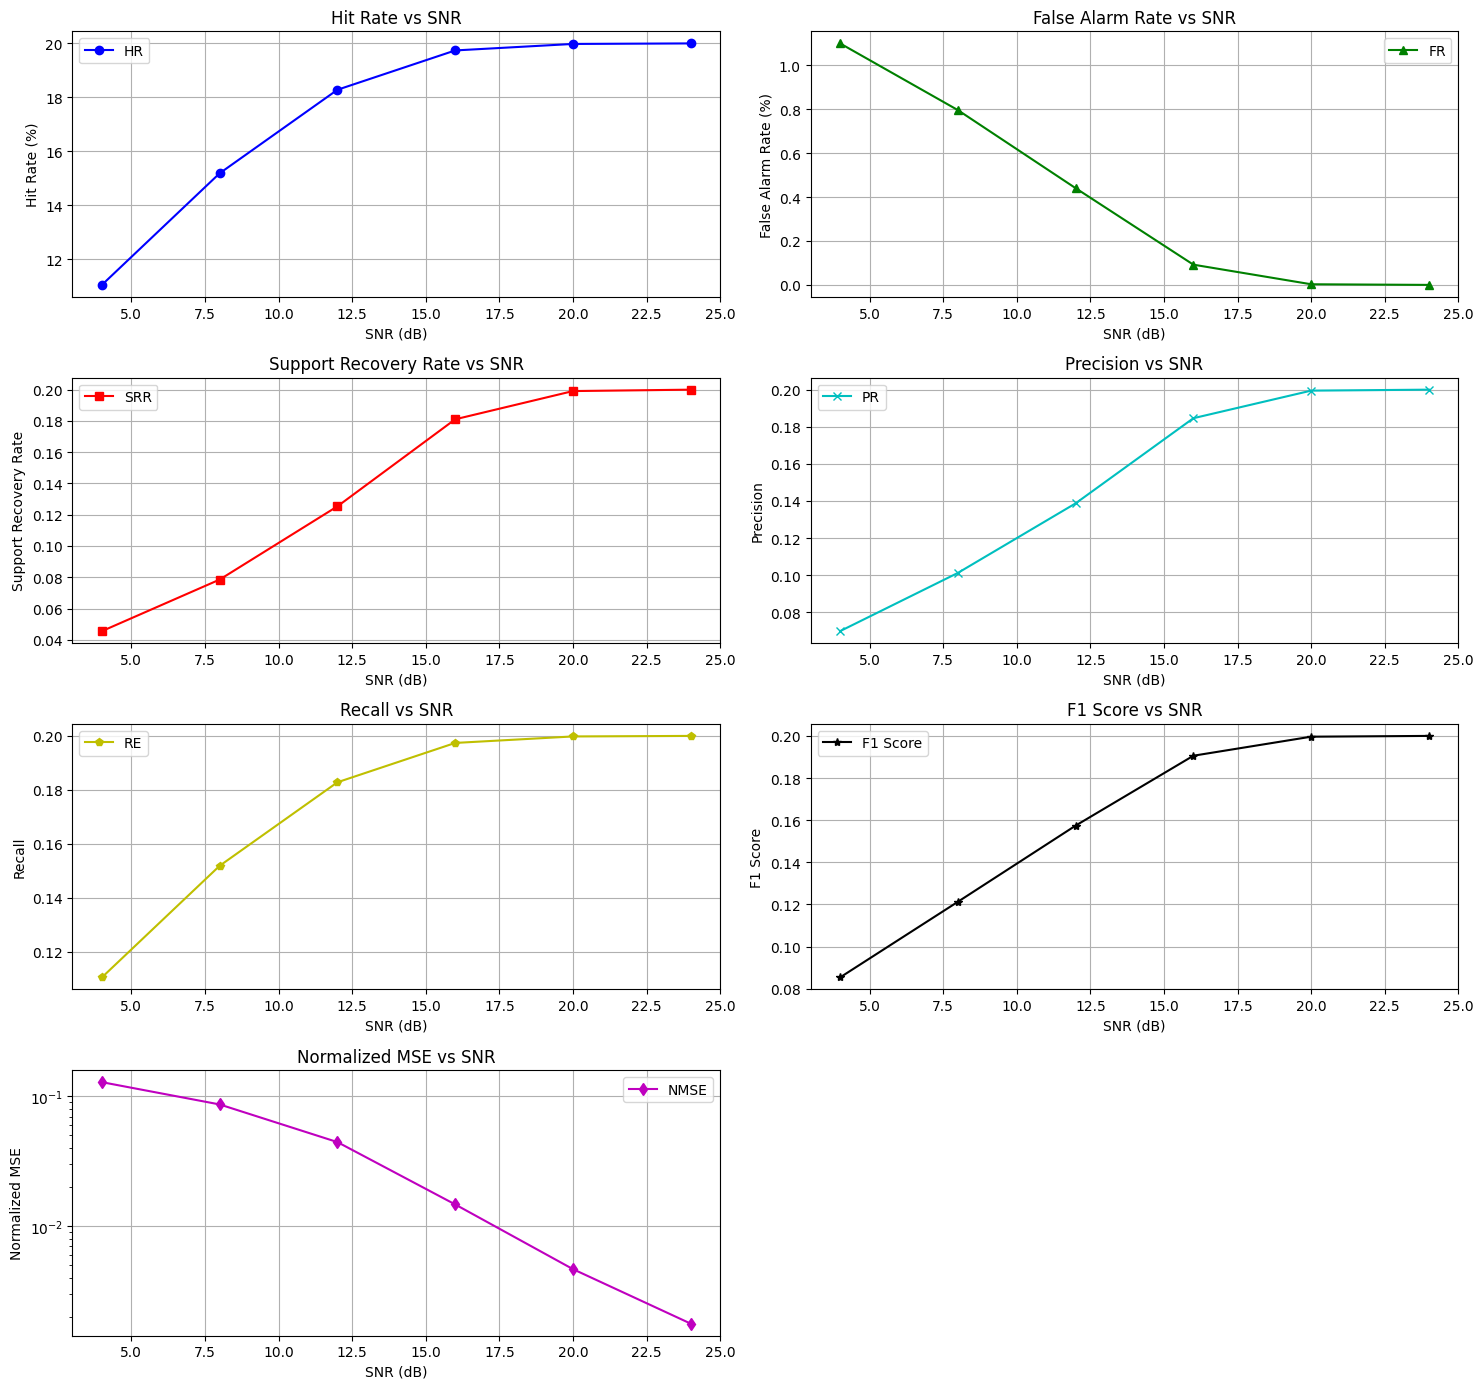

In [9]:
import matplotlib.pyplot as plt

# Define the SNR values for x-axis
snr_values = snr_db_array

# Create subplots for different performance metrics
plt.figure(figsize=(15, 14))

# Plot Hit Rate (HR)
plt.subplot(4, 2, 1)
plt.plot(snr_values, avg_hr, marker='o', linestyle='-', color='b', label='HR')
plt.xlabel("SNR (dB)")
plt.ylabel("Hit Rate (%)")
plt.title("Hit Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot False Alarm Rate (FR)
plt.subplot(4, 2, 2)
plt.plot(snr_values, avg_fr, marker='^', linestyle='-', color='g', label='FR')
plt.xlabel("SNR (dB)")
plt.ylabel("False Alarm Rate (%)")
plt.title("False Alarm Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Support Recovery Rate (SRR)
plt.subplot(4, 2, 3)
plt.plot(snr_values, avg_srr, marker='s', linestyle='-', color='r', label='SRR')
plt.xlabel("SNR (dB)")
plt.ylabel("Support Recovery Rate")
plt.title("Support Recovery Rate vs SNR")
plt.grid(True)
plt.legend()

# Plot Precision (PR)
plt.subplot(4, 2, 4)
plt.plot(snr_values, avg_pr, marker='x', linestyle='-', color='c', label='PR')
plt.xlabel("SNR (dB)")
plt.ylabel("Precision")
plt.title("Precision vs SNR")
plt.grid(True)
plt.legend()

# Plot Recall (RE)
plt.subplot(4, 2, 5)
plt.plot(snr_values, avg_re, marker='p', linestyle='-', color='y', label='RE')
plt.xlabel("SNR (dB)")
plt.ylabel("Recall")
plt.title("Recall vs SNR")
plt.grid(True)
plt.legend()

# Plot F1 Score (F1)
plt.subplot(4, 2, 6)
plt.plot(snr_values, avg_f1, marker='*', linestyle='-', color='k', label='F1 Score')
plt.xlabel("SNR (dB)")
plt.ylabel("F1 Score")
plt.title("F1 Score vs SNR")
plt.grid(True)
plt.legend()

# Plot Normalized MSE (NMSE)
plt.subplot(4, 2, 7)
plt.plot(snr_values, avg_nmse, marker='d', linestyle='-', color='m', label='NMSE')
plt.xlabel("SNR (dB)")
plt.ylabel("Normalized MSE")
plt.title("Normalized MSE vs SNR")
plt.yscale('log')  # Log scale for better visualization
plt.grid(True)
plt.legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_res_vs_ground_truth(sbl_results, Z, sample_index, snr_index, snr_value):
    """Plot sbl reconstructed signal vs ground truth (Z) for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    # Ground truth (Z)
    plt.plot(np.abs(Z[sample_index,:,0]), marker='s', linestyle='--', color='g', label="Ground Truth (Z)")

    # sbl Estimated Signal
    plt.plot(np.abs(sbl_results[sample_index, snr_index, :, 0]), marker='o', linestyle='-', color='b', label="sbl Estimate")

    plt.xlabel("Device Index")
    plt.ylabel("Magnitude of Signal")
    plt.title(f"sbl vs. Ground Truth (Sample {sample_index}, SNR {snr_value} dB)")
    plt.legend()
    plt.grid(True)
    plt.show()

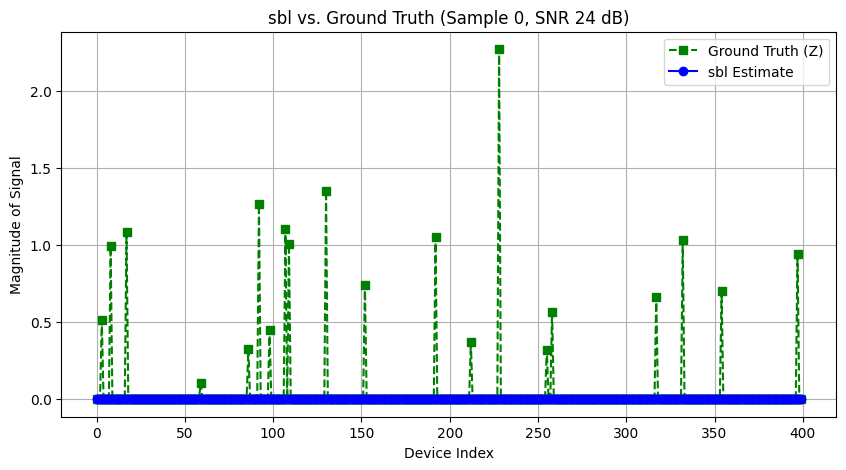

In [11]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_res_vs_ground_truth(z_res, all_z, sample_index, snr_index, snr_value)

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def plot_gamma_res_vs_ground_truth(gamma_res, gamma_true, sample_index, snr_index, snr_value):
    """Plot sbl estimated gamma vs ground truth gamma for a single sample at a given SNR."""
    plt.figure(figsize=(10, 5))

    device_indices = np.arange(len(gamma_true[sample_index]))  # X-axis: Device indices

    # Plot ground truth gamma (binary)
    plt.stem(device_indices, gamma_true[sample_index], linefmt='g--', markerfmt='gs', basefmt=" ", label="Ground Truth (γ)")

    # Plot sbl estimated gamma
    plt.stem(device_indices, gamma_res[sample_index, snr_index], linefmt='b-', markerfmt='bo', basefmt=" ", label="sbl Estimate (γ)")

    plt.xlabel("Device Index")
    plt.ylabel("Activity Indicator (0=Inactive, 1=Active)")
    plt.title(f"Device Activity (sbl vs. Ground Truth) - Sample {sample_index}, SNR {snr_value} dB")
    plt.legend()
    plt.grid(True)
    plt.show()


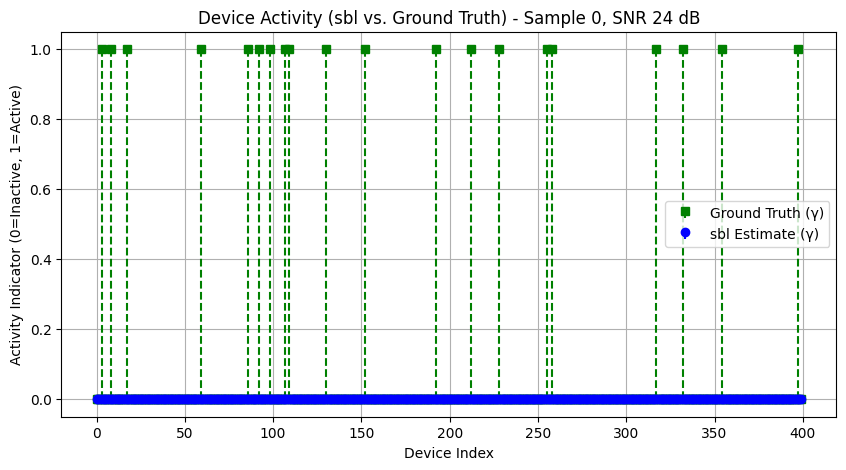

In [13]:
sample_index = 0  # Choose a specific sample
snr_index = 5  # Choose a specific SNR index
snr_value = snr_db_array[snr_index]

plot_gamma_res_vs_ground_truth(gamma_res, all_gamma, sample_index, snr_index, snr_value)